In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
from sklearn.model_selection import train_test_split
from scipy import stats

%matplotlib inline
matplotlib.style.use('bmh')

In [ ]:
data_all_thomas = pd.read_excel('annotations/data_all_thomas.xlsx')
data_labels_video_features = pd.read_csv('annotations/combined_labels_video_features.csv')
labels = data_labels_video_features[['gold_gt_max_aro','gold_gt_max_like','gold_gt_max_val','gold_gt_min_aro','gold_gt_min_like','gold_gt_min_val']]
labels_max = labels[['gold_gt_max_aro','gold_gt_max_like','gold_gt_max_val']]
labels_min = labels[['gold_gt_min_aro','gold_gt_min_like','gold_gt_min_val']]
video_features = data_labels_video_features.drop(['gold_gt_max_aro','gold_gt_max_like','gold_gt_max_val','gold_gt_min_aro','gold_gt_min_like','gold_gt_min_val'],axis=1)

In [ ]:
#Applying z normalization
video_features = video_features.apply(stats.zscore)

In [ ]:
#Applying L2 normalization
video_features = pd.DataFrame(sk.preprocessing.normalize(video_features, norm='l2',axis=1))

[Text(175.0725, 199.32, 'X[3] <= 1.5\ngini = 0.493\nsamples = 592\nvalue = [422, 538]'),
 Text(89.28, 163.07999999999998, 'X[0] <= 1.5\ngini = 0.316\nsamples = 278\nvalue = [360, 88]'),
 Text(44.64, 126.83999999999999, 'X[4] <= 1.5\ngini = 0.145\nsamples = 207\nvalue = [305, 26]'),
 Text(22.32, 90.6, 'X[1] <= 1.5\ngini = 0.1\nsamples = 166\nvalue = [252, 14]'),
 Text(11.16, 54.359999999999985, 'X[2] <= 1.5\ngini = 0.08\nsamples = 148\nvalue = [231, 10]'),
 Text(5.58, 18.119999999999976, 'gini = 0.062\nsamples = 137\nvalue = [213, 7]'),
 Text(16.740000000000002, 18.119999999999976, 'gini = 0.245\nsamples = 11\nvalue = [18, 3]'),
 Text(33.480000000000004, 54.359999999999985, 'X[2] <= 1.5\ngini = 0.269\nsamples = 18\nvalue = [21, 4]'),
 Text(27.9, 18.119999999999976, 'gini = 0.172\nsamples = 16\nvalue = [19, 2]'),
 Text(39.06, 18.119999999999976, 'gini = 0.5\nsamples = 2\nvalue = [2, 2]'),
 Text(66.96000000000001, 90.6, 'X[1] <= 1.5\ngini = 0.301\nsamples = 41\nvalue = [53, 12]'),
 Text(5

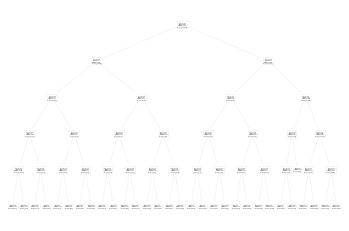

In [15]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


x_train_bin = data_all_thomas[['agreeableness_binary','conscientiousness_binary','extraversion_binary','neuroticism_binary','openness_binary']]
x_train_bin_mood = data_all_thomas[['arousal','valence','likeability']]
y_train_bin = data_all_thomas[['interview_binary']]

rf = RandomForestClassifier(n_estimators=100, bootstrap=True, max_features='sqrt')
rf.fit(x_train_bin,y_train_bin)
tree.plot_tree(rf.estimators_[0])

In [29]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


x_train_bin = data_all_thomas[['agreeableness_binary','conscientiousness_binary','extraversion_binary','neuroticism_binary','openness_binary']]
x_train_bin_mood = data_all_thomas[['arousal','valence','likeability']]
x_train_bin_combined = data_all_thomas[['agreeableness_binary','conscientiousness_binary','extraversion_binary','neuroticism_binary','openness_binary','arousal','valence','likeability']]
y_train_bin = data_all_thomas[['interview_binary']]
clf = DecisionTreeClassifier(random_state=50, max_depth=5,min_samples_leaf=30)
clf.fit(x_train_bin_combined, y_train_bin)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=50, splitter='best')

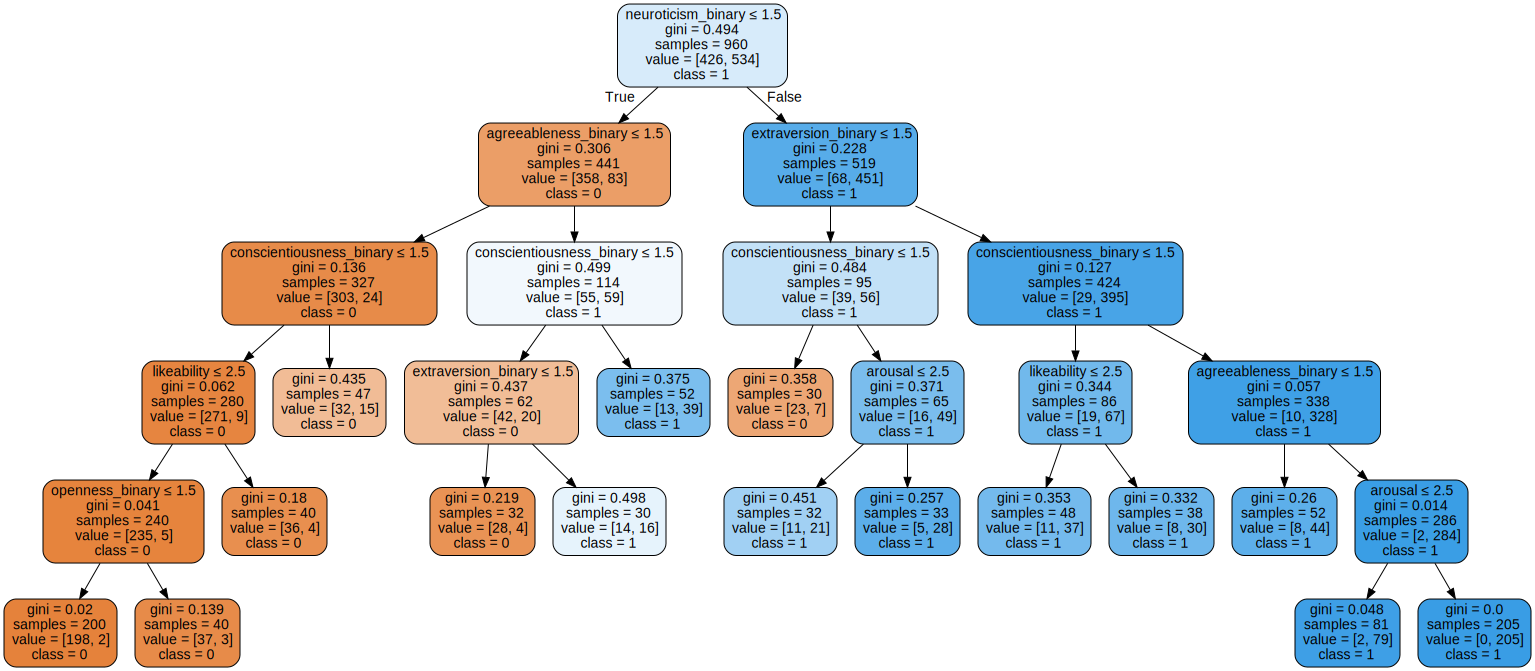

In [30]:
import graphviz 


dot_data = tree.export_graphviz(clf, out_file=None,feature_names=x_train_bin_combined.columns,class_names=['0','1'],filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)
graph 

In [ ]:
#Support Vector Machine
from sklearn.metrics import classification_report, confusion_matrix,recall_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(video_features, labels['gold_gt_min_aro'], train_size=660,test_size=300,shuffle=False)

#Gridsearching best parameters
param_grid = [{ 'kernel': ['linear'],'tol':[1,0.1,0.01,0.001,0.0001]}]
#param_grid = [{'C': [1,0.00001], 'kernel': ['linear']}]
svc = SVC()
#Scoring based on recall macro average score
clf = GridSearchCV(svc,param_grid, scoring='recall_macro')
clf.fit(X_train,y_train)
results = clf.cv_results_

In [ ]:
#best estimator based on param grid search
y_pred = clf.best_estimator_.predict(X_test)
report_best_estimator = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()


In [ ]:
#multiple SVM
from sklearn.metrics import classification_report, confusion_matrix,recall_score
from sklearn.svm import SVC


variables = [labels['gold_gt_min_aro'],labels['gold_gt_min_like'],labels['gold_gt_min_val'],data_all_thomas['arousal'],data_all_thomas['likeability'],data_all_thomas['valence']]
hyperparams_c = [100000,10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]
gammas = [100000,10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]
report_svms = pd.DataFrame(columns=['variable_name'] + gammas)

for variable in variables:
    row = [variable.name]
    for gamma_p in gammas:
        X_train, X_test, y_train, y_test = train_test_split(video_features, variable, train_size=660,test_size=300,shuffle=False)
        clf_single = SVC(kernel='rbf', C=10,gamma=gamma_p)
        clf_single.fit(X_train,y_train)
        y_pred_single = clf_single.predict(X_test)
        row = row + [recall_score(y_test, y_pred_single,average='macro')]
        #report_svms = report_svms.append([[variable.name]])
        #report_svms = report_svms.append([recall_score(y_test, y_pred_single,average='macro')])
        #report_svms = report_svms.append(pd.DataFrame(classification_report(y_test,y_pred_single, output_dict=True)).transpose())
    report_svms = report_svms.append(pd.Series(row,index=report_svms.columns),ignore_index=True)

report_svms.to_csv('report_svms_c_linear.csv')



In [ ]:
report_svms.to_csv('report_svms_c_linear.csv')


In [ ]:
#single SVM
from sklearn.metrics import classification_report, confusion_matrix,recall_score
from sklearn.svm import SVC


X_train, X_test, y_train, y_test = train_test_split(video_features, data_all_thomas['interview'] , train_size=660,test_size=300,shuffle=False)
clf_single = SVC(kernel='linear', C=1)
clf_single.fit(X_train,y_train)
y_pred_single = clf_single.predict(X_test)
recall_score(y_test, y_pred_single,average='macro')

In [ ]:
#Logistic regression
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(video_features, labels['gold_gt_min_val'], train_size=660,test_size=300,shuffle=False)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test,y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('report.csv')

In [ ]:
#Boxplots
def save_boxplot(x,y):
    box_data_1 = data_all_thomas[data_all_thomas[x] == 1 ].get(y)
    box_data_2 = data_all_thomas[data_all_thomas[x] == 2 ].get(y)
    box_data_3 = data_all_thomas[data_all_thomas[x] == 3 ].get(y)
    box_data = [box_data_1,box_data_2,box_data_3]
    fig, ax = plt.subplots()
    ax.boxplot(box_data)
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    fig.savefig('boxplots/boxplot_'+x+'_'+y+'.svg')


def create_boxplots():
    classifications = ['agreeableness','conscientiousness','extraversion','interview','neuroticism','openness']
    variables = ['valence','arousal','likeability']
    for x in variables:
        for y in classifications:
            save_boxplot(x,y)

In [ ]:
#Basis statistics
def stats(x):
    data_class_1 = data_all_thomas[data_all_thomas[x] == 1 ].get('interview')
    data_class_2 = data_all_thomas[data_all_thomas[x] == 2 ].get('interview')
    data_class_3 = data_all_thomas[data_all_thomas[x] == 3 ].get('interview')
    print('data1: mean=%.3f stdv=%.3f' % (np.mean(data_class_1), np.std(data_class_1)))
    print('data2: mean=%.3f stdv=%.3f' % (np.mean(data_class_2), np.std(data_class_2)))
    print('data3: mean=%.3f stdv=%.3f' % (np.mean(data_class_3), np.std(data_class_3)))    
    stat, p = ttest_ind(data_class_2, data_class_3) 
    print(stat, p)

In [ ]:
#Statistical significance
def mannWithNeyuScore():
    data_class_1 = data_all_thomas[data_all_thomas['likeability'] == 1 ].get('interview')
    data_class_2 = data_all_thomas[data_all_thomas['likeability'] == 2 ].get('interview')
    data_class_3 = data_all_thomas[data_all_thomas['likeability'] == 3 ].get('interview')
    scipy.stats.mannwhitneyu(data_class_1, data_class_3)